## This is a descriptive analysis to verify the current state of the elections of 2022 in toulouse for participatory budget

This notebook is based on the output of another notebook that was created by Juan Ignacio

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading the datasources

In [2]:
aggregatedProjectsDF = pd.read_csv('projectsAgg2.csv',sep=";")
electionDetailsDF = pd.read_csv('projectDetails.csv', sep=";")
xlsx = pd.ExcelFile('/home/samuelaga/Documents/Master2IS/Stage M1/M2IS-Internship-XAI/PBToulouse2022/Copie de Resultats BP31102022-.xlsx')
electionResultsDF = pd.read_excel(xlsx,'lauréats')
##Drop the last summary row in the dataframe
electionResultsDF.drop(electionResultsDF.tail(1).index,inplace=True)

print("Election aggregated projects", aggregatedProjectsDF.columns,"\n")
print("Election details",electionDetailsDF.columns,"\n")
print("Election results", electionResultsDF.columns,"\n")

Election aggregated projects Index(['project_id', 'project_name', 'description', 'category', 'cost',
       'district', 'votes'],
      dtype='object') 

Election details Index(['ID', 'project_id', 'project_title', 'created_at', 'checked_out_at',
       'project_url', 'vote_finished'],
      dtype='object') 

Election results Index(['Quartier', 'Catégorie', 'Titre de l'idée', 'Montant', 'VOIX',
       'Total par quartier', 'Hypothèse \nRepêchage', 'Nb projets'],
      dtype='object') 



In [3]:
electionDetailsDF['created_at'] = pd.to_datetime(electionDetailsDF['created_at'])
electionDetailsDF['checked_out_at'] = pd.to_datetime(electionDetailsDF['checked_out_at'])
electionDetailsDF['session_duration'] = electionDetailsDF['checked_out_at'] - electionDetailsDF['created_at']
aggregatedProjectsDF['title_length'] = aggregatedProjectsDF['project_name'].str.len()
aggregatedProjectsDF['description_length'] = aggregatedProjectsDF['description'].str.len()

#### Performing some cleaning and mapping before analyzing

In [4]:
##Unique districts from the aggregated projects
print(aggregatedProjectsDF['district'].unique())
print(len(aggregatedProjectsDF['district'].unique()))

##Separating district number from the district description
## add_district_code stands for district code from the aggregated values (most likely the data that was scraped had different codes than the
## source data)
aggregatedProjectsDF[['agg_district_code', 'agg_quartiers']] = aggregatedProjectsDF['district'].str.extract(r'^(\d+)\s*-\s*(.+)$')
aggregatedProjectsDF['agg_district_code'] = aggregatedProjectsDF['agg_district_code'].astype(int)
print(aggregatedProjectsDF['agg_district_code'].unique())
print(len(aggregatedProjectsDF['agg_district_code'].unique()))


['12 - Pont des Demoiselles / Ormeau / Montaudran / La Terrasse / Malepère'
 '8 - Minimes / Barrière de Paris / Ponts-Jumeaux / La Vache / Raisins / Fondeyre'
 "11 - Bonhoure / Guilheméry / Château de l'Hers / Limayrac / Côte Pavée"
 '5 - Saint-Michel / Saint-Agne / Empalot / Le Busca / Ile du Ramier / Monplaisir'
 '7 - Sept Deniers / Ginestous-Sesquières / Lalande'
 "15 - Croix de Pierre / Route d'Espagne"
 '17 - Mirail-Université / Reynerie / Bellefontaine'
 '9 - Trois Cocus / Borderouge / Croix-Daurade / Paléficat / Grand Selve'
 '4 - Lapujade / Bonnefoy / Périole / Marengo / La Colonne'
 '18 - Lardenne / Pradettes / Basso-Cambo'
 '20 - Arènes Romaines / Ancely / Saint-Martin du Touch / Purpan'
 '1 - Capitole / Arnaud Bernard / Carmes'
 '13 - Rangueil / Sauzelong / Jules-Julien / Pech-David / Pouvourville'
 '14 - Saint-Simon / Lafourguette / Oncopole-Campus Santé du Futur'
 '6 - Saint-Cyprien'
 '16 - Fontaine-Lestang / Arènes / Bagatelle / Papus / Tabar / Bordelongue / Mermoz / La F

In [5]:
##Unique districts from the election results
print(electionResultsDF['Quartier'].unique())
print(len(electionResultsDF['Quartier'].unique()))

##Separating the district number from the district description
## src_district_code stand for source district code and it refers to the distric codes that were inputted in the dataset from 2022
electionResultsDF[['src_district_code','src_quartiers']] = electionResultsDF['Quartier'].str.extract(r'([0-9]+\.[0-9]+)\s*-\s*(.*)')
print(electionResultsDF['src_district_code'].unique())
print(len(electionResultsDF['src_district_code'].unique()))

['1.1 - Capitole / Arnaud Bernard / Carmes'
 '1.2 - Amidonniers / Compans-Caffarelli'
 '1.3 - Les Chalets / Bayard / Belfort / Saint Aubin / Dupuy'
 '2.1 - Saint-Cyprien' "2.2 - Croix-de-Pierre / Route d'Espagne"
 '2.3 - Fontaine-Lestang / Arènes / Bagatelle / Papus / Tabar / Bordelongue / Mermoz / La Faourette'
 '2.4 - Casselardit / Fontaine-Bayonne / Cartoucherie'
 '3.1 - Minimes / Barrière de Paris / Ponts-Jumeaux'
 '3.2 - Sept-Deniers / Ginestous / Lalande'
 '3.3 - Trois Cocus / Borderouge / Croix Daurade / Paléficat / Grand Selve'
 '4.1 - Lapujade / Bonnefoy / Périole / Marengo / La Colonne'
 '4.2 - Jolimont / Soupetard / Roseraie / Gloire / Gramont / Amouroux'
 "4.3 - Bonhoure / Guilheméry / Château de l'Hers / Limayrac / Côte Pavée"
 '5.1 - Pont des Demoiselles / Ormeau / Montaudran / La Terrasse / Malepère'
 '5.2 - Rangueil / Sauzelong / Pech-David / Pouvourville'
 '5.3 - Saint-Michel / Le Busca / Empalot / Saint-Agne / Ile du Ramier'
 '6.1 - Arènes Romaines / Saint-Martin-du-T

In [6]:
##Preparation to merge the district codes from the source to the aggregated dataset
district_mapping = {
    1: '1.1', 2: '1.2', 3: '1.3', 4: '4.1', 5: '5.3', 6: '2.1', 
    7: '3.2', 8: '3.1', 9: '3.3', 10: '4.2', 11: '4.3', 12: '5.1', 
    13: '5.2', 14: '6.4', 15: '2.2', 16: '2.3', 17: '6.3', 18: '6.2', 
    19: '2.4', 20: '6.1'
}

aggregatedProjectsDF['src_district_code'] = aggregatedProjectsDF['agg_district_code'].map(district_mapping)

print(aggregatedProjectsDF[['src_district_code','agg_district_code']].drop_duplicates())


   src_district_code  agg_district_code
0                5.1                 12
1                3.1                  8
2                4.3                 11
3                5.3                  5
6                3.2                  7
7                2.2                 15
8                6.3                 17
9                3.3                  9
13               4.1                  4
15               6.2                 18
18               6.1                 20
21               1.1                  1
22               5.2                 13
26               6.4                 14
27               2.1                  6
32               2.3                 16
35               1.3                  3
38               1.2                  2
42               2.4                 19
51               4.2                 10


In [7]:
##Create a column in the aggregated dataframe to enrich the analysis
#aggregatedProjectsDF['approved'] = aggregatedProjectsDF['project_name'].isin(electionResultsDF["Titre de l'idée"]) & aggregatedProjectsDF['src_district_code'].isin(electionResultsDF["src_district_code"])
print(aggregatedProjectsDF)

     project_id                                       project_name  \
0           132                              Lutte anti-moustiques   
1            78                 Réhabiliter l’impasse des Minimes    
2           122  Aire convivialité espace vert rue de l'Isére /...   
3           149  Un jardin en mouvement le long de la voie ferr...   
4           129     Zone de Street Workout - Parc de la boisseraie   
..          ...                                                ...   
194          98                               Equipements sportifs   
195          88  Remplacer les feux tricolores actuels de la Ro...   
196         109  Création d'une Venelle  quartier Soupetard Ros...   
197         131                 Le développement de l'auto partage   
198          32  Garder arbres, espaces aérés et terrains de fo...   

                                           description         category  \
0    Mise en place de pièges à moustiques dans le q...  Nature en ville   
1    L’Im

In [8]:
#duplicated_titles = aggregatedProjectsDF[aggregatedProjectsDF['project_name'].duplicated(keep=False)]
#print(duplicated_titles[['project_id', 'project_name','district']])
#print(aggregatedProjectsDF['approved'].sum())


# Create a set of tuples from 'Titre de l'idée' and 'src_district_code' columns in electionResultsDF
election_results_tuples = set(zip(electionResultsDF['Titre de l\'idée'], electionResultsDF['src_district_code']))

# Create the 'approved' column by checking if the combination of 'project_name' and 'src_district_code' exists in the set
aggregatedProjectsDF['approved'] = aggregatedProjectsDF.apply(
    lambda row: (row['project_name'], row['src_district_code']) in election_results_tuples, axis=1
)

aggregatedProjectsDF['approved_binary'] = aggregatedProjectsDF['approved'].astype(int)

In [9]:
print(aggregatedProjectsDF.columns)

Index(['project_id', 'project_name', 'description', 'category', 'cost',
       'district', 'votes', 'title_length', 'description_length',
       'agg_district_code', 'agg_quartiers', 'src_district_code', 'approved',
       'approved_binary'],
      dtype='object')


#### Exploratory analysis
The following questions are going to be the base for the analysis and then we can improve from that

**Total number of projects**

In [10]:
print(len(aggregatedProjectsDF))

199


**Total number of voters**

In [11]:
print(len(electionDetailsDF["ID"].unique()))

4532


**Count of voters per project**

In [12]:
print(aggregatedProjectsDF[['project_id','votes']].sort_values('votes', ascending=False))

     project_id  votes
62          136    492
50            7    467
23            5    358
0           132    258
100          71    243
..          ...    ...
8           181      2
20           50      2
79          187      2
157         176      2
148         178      2

[199 rows x 2 columns]


**What are the avaliable categories of projects?**

In [13]:
print(aggregatedProjectsDF['category'].unique())

['Nature en ville' 'Cadre de vie' 'Éco-mobilité'
 'Consommation responsable' 'Énergie' 'Déchets et Recyclage']


**Frequency distribution of the voters**  
How many voters voted only for one project, two projects and three projects

In [14]:
voters_project_count = electionDetailsDF.groupby('ID')['project_title'].nunique()
print(voters_project_count.value_counts().sort_index())

project_title
1     872
2     250
3    3410
Name: count, dtype: int64


**How many projects were proposed per district**  

In [15]:
projects_per_district = aggregatedProjectsDF.groupby('agg_district_code')['project_name'].nunique()
print(projects_per_district)

agg_district_code
1     10
2     10
3     10
4     10
5     10
6     10
7     10
8     10
9      9
10    10
11    10
12    10
13    10
14    10
15    10
16    10
17    10
18    10
19    10
20    10
Name: project_name, dtype: int64


**Votes per district**  


In [16]:
votes_per_district = aggregatedProjectsDF.groupby('agg_district_code')['votes'].sum()
votes_per_district_sorted = votes_per_district.sort_values(ascending=False)
print(votes_per_district_sorted)

agg_district_code
1     1369
12    1169
6      778
5      768
8      752
10     714
18     622
2      582
13     557
3      524
19     498
15     451
20     438
11     436
4      410
14     404
16     392
9      329
7      308
17     105
Name: votes, dtype: int64


**Votes per category**  

In [17]:
votes_per_category = aggregatedProjectsDF.groupby('category')['votes'].sum()
votes_per_category_sorted = votes_per_category.sort_values(ascending=False)
print(votes_per_category_sorted)

category
Nature en ville             5936
Éco-mobilité                2562
Cadre de vie                2281
Énergie                      531
Déchets et Recyclage         235
Consommation responsable      61
Name: votes, dtype: int64


**Max project budget**  

In [18]:
print(aggregatedProjectsDF['cost'].max())

200000.0


**Min project budget**  

In [19]:
print(aggregatedProjectsDF['cost'].min())

1200.0


**Mean project budget**  

In [20]:
print(aggregatedProjectsDF['cost'].mean())

79586.53266331658


**Min session time**  
The duration of a voting process, the timediff between the checked out time and the vote finished time

In [21]:
print(electionDetailsDF['session_duration'].min())

0 days 00:00:02.102000


**Max session time**

In [22]:
print(electionDetailsDF['session_duration'].max())

23 days 05:08:02.164000


**Mean session time**

In [23]:
print(electionDetailsDF['session_duration'].mean())

0 days 04:39:04.790282612


**How well the title lenght correlates to the approval of the project**  

In [24]:
correlation_title = aggregatedProjectsDF['title_length'].corr(aggregatedProjectsDF['approved_binary'])
print(f"Correlation between title length and approval: {correlation_title}")

Correlation between title length and approval: 0.12025577226355394


**How well the description lenght correlates to the approval of the project**  

In [25]:
correlation_description = aggregatedProjectsDF['description_length'].corr(aggregatedProjectsDF['approved_binary'])
print(f"Correlation between title length and approval: {correlation_description}")

Correlation between title length and approval: 0.19023653907295024


/tmp/ipykernel_25950/859744724.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_sessions['session_duration_seconds'] = unique_sessions['session_duration'].dt.total_seconds()


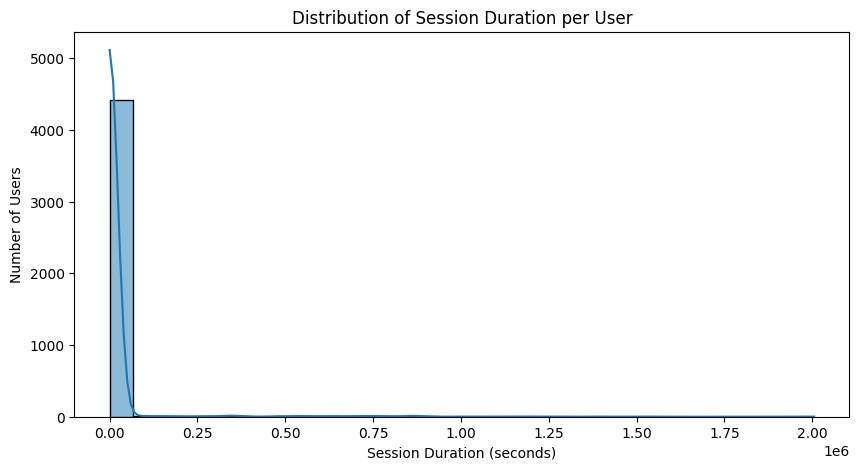

In [26]:
# Step 1: Get one row per user
unique_sessions = electionDetailsDF.drop_duplicates(subset='ID')
# Step 2: Convert session_duration to seconds (if it's a timedelta)
unique_sessions['session_duration_seconds'] = unique_sessions['session_duration'].dt.total_seconds()

# Step 3: Plot histogram of session durations
plt.figure(figsize=(10, 5))
sns.histplot(unique_sessions['session_duration_seconds'], bins=30, kde=True)
plt.title('Distribution of Session Duration per User')
plt.xlabel('Session Duration (seconds)')
plt.ylabel('Number of Users')
plt.show()